In [ ]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision.transforms as transforms
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
        
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

## Deuxième version, parce que la première marche pas -> inspiré du cours

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

In [ ]:
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
        
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        num_channels = 1
        num_classes = 10
        in_channels = num_channels + num_classes
        self.label_embedding = nn.Embedding(num_classes, img_rows*img_cols*num_classes) # Permet d'encoder les labels pour pouvoir les concaténer avec l'entrée du discriminateur... 
                                                                   # donc représentation des 10 classes dans des matrices de (28x28) dimensions 
                                                                   # (avec 28x28 correspondant à une image en entrée de discriminateur)
                                                                   # => Encodage des labels dans une matrice de dimensions 10x28x28
        self.model = nn.Sequential(
            # Convolutional layer, from 28x28x2 into 14x14x64 tensor
            nn.Conv2d(num_channels, 16, kernel_size=4, stride=2),
            # Batch normalization
            nn.BatchNorm2d(16),
            # Leaky ReLU activation
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            # Convolutional layer, from 14x14x64 into 7x7x64 tensor
            nn.Conv2d(16,32,kernel_size=4,stride=2),
            # Batch normalization
            nn.BatchNorm2d(32),     
            # Leaky ReLU activation
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Conv2d(32,1,kernel_size=4,stride=2),

            #nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            # Batch normalization
            #nn.BatchNorm2d(256),     
            # Leaky ReLU activation
            #nn.LeakyReLU(0.01),
  
            # Output layer with sigmoid activation
            #nn.Flatten(),
            #nn.Sigmoid()
        )


    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)
        #x = x.Reshape(1,28,28)
        #c = self.label_embedding(labels)
        #c = c.view(x.size(0), 10, 28, 28)
        #c = c.Reshape(10,28,28)
        #x = torch.cat([x, c], dim=1)
        output = self.model(x)
        output = output.view(len(output),1)
        return output

In [ ]:
discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (label_embedding): Embedding(10, 7840)
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)


### Generator

In [ ]:
z_dim = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        latent_dim = 100
        num_classes = 10
        input_dim = latent_dim + num_classes
        self.label_embedding = nn.Embedding(num_classes, 10) # Correspond à une autre représentation du one_hot_encode: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
                                                             # Permet d'encoder les labels de mnist dans un tenseur de 10 valeurs (matrice de 10x10 pour 10 classes
                                                             # => 0 = [1000000000])
                                                             # => 1 = [0100000000])
                                                             # ....

        self.model = nn.Sequential(
            # Reshape input into 7x7x256 tensor via a fully connected layer
            #nn.Linear(z_dim,256*7*7),
            #Reshape((256,7,7,)),
            #nn.BatchNorm1d(7*7*256),
            #nn.ReLU(),
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=3,stride=2),#,padding=1,output_padding=1)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
            nn.ConvTranspose2d(256,128,kernel_size=4,stride=1),  #,padding=1,output_padding=1),
            # Batch normalization
            nn.BatchNorm2d(128),
            # Leaky ReLU activation
            nn.ReLU(),
            # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2),   #,padding=1),
            # Batch normalization
            nn.BatchNorm2d(64),
            # Leaky ReLU activation
            nn.ReLU(),
            # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
            nn.ConvTranspose2d(64,1,kernel_size=4,stride=2),   #,padding=1,output_padding=1),
            # Output layer with tanh activation
            nn.Tanh()
        )
        

    def forward(self, x):
        #c = self.label_embedding(labels)
        #x = torch.cat([x,c], 1)
        #output = self.fc(x)
        #output = output.view(-1, 256, 7, 7)
        x=x.view(len(x),z_dim,1,1)
        output = self.model(x)
        #output = output.view(-1, 1, 28, 28)
        return output

In [ ]:
generator = Generator().to(device)
print(generator)

Generator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (10): Tanh()
  )
)


### Training

In [ ]:
lr_g = 1e-4
lr_d = 1e-5
lr = 1e-4
num_epochs = 50
loss_function = nn.BCEWithLogitsLoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr,betas = (0.5,0.9))   
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr,betas = (0.5,0.9))

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
latent_space_samples_plot = torch.randn((batch_size, 100)).to(device=device)

Epoch: 0 Loss D.: 1.2122302055358887
Epoch: 0 Loss G.: 0.18794004619121552


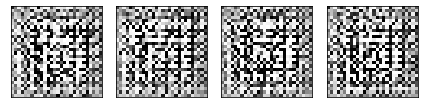

Epoch: 1 Loss D.: 0.6926450729370117
Epoch: 1 Loss G.: 0.6355724334716797


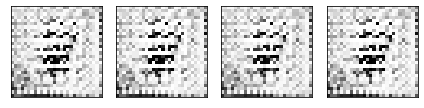

Epoch: 2 Loss D.: 0.676186203956604
Epoch: 2 Loss G.: 0.7310181856155396


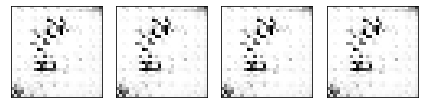

Epoch: 3 Loss D.: 0.4671036899089813
Epoch: 3 Loss G.: 1.179929494857788


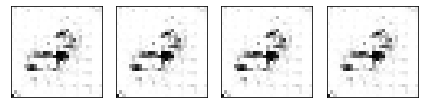

Epoch: 4 Loss D.: 0.7699625492095947
Epoch: 4 Loss G.: 0.7636466026306152


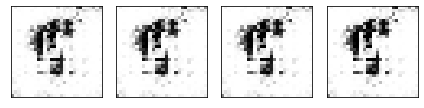

Epoch: 5 Loss D.: 0.9131664633750916
Epoch: 5 Loss G.: 0.8195537328720093


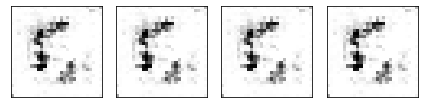

Epoch: 6 Loss D.: 0.565428614616394
Epoch: 6 Loss G.: 0.9752820134162903


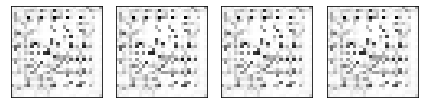

Epoch: 7 Loss D.: 0.6304140090942383
Epoch: 7 Loss G.: 1.113224744796753


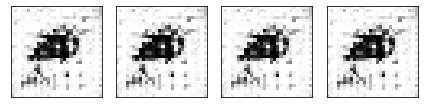

Epoch: 8 Loss D.: 0.5356600284576416
Epoch: 8 Loss G.: 0.6327097415924072


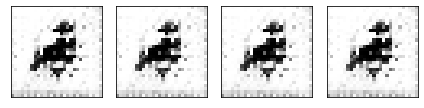

Epoch: 9 Loss D.: 0.4265490174293518
Epoch: 9 Loss G.: 2.295574426651001


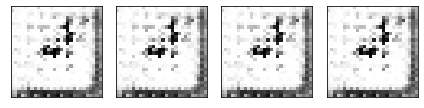

Epoch: 10 Loss D.: 0.2353781908750534
Epoch: 10 Loss G.: 2.214794635772705


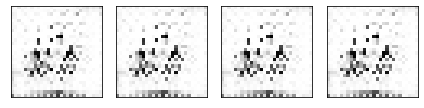

Epoch: 11 Loss D.: 0.557911217212677
Epoch: 11 Loss G.: 1.5915560722351074


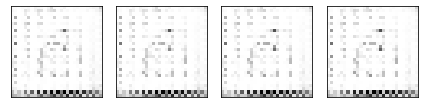

Epoch: 12 Loss D.: 0.7630482912063599
Epoch: 12 Loss G.: 0.8439948558807373


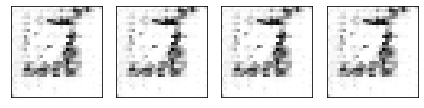

Epoch: 13 Loss D.: 0.7069144248962402
Epoch: 13 Loss G.: 1.2148096561431885


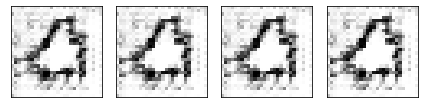

Epoch: 14 Loss D.: 0.9418410658836365
Epoch: 14 Loss G.: 0.6274505257606506


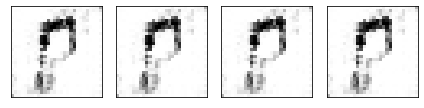

Epoch: 15 Loss D.: 0.7248947620391846
Epoch: 15 Loss G.: 0.9806891679763794


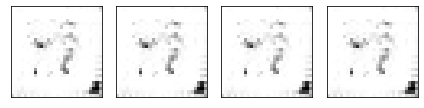

Epoch: 16 Loss D.: 0.6289020776748657
Epoch: 16 Loss G.: 0.9052389860153198


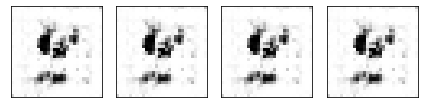

Epoch: 17 Loss D.: 1.2775864601135254
Epoch: 17 Loss G.: 0.47994279861450195


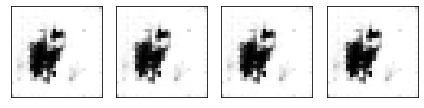

Epoch: 18 Loss D.: 0.6986495852470398
Epoch: 18 Loss G.: 1.2698936462402344


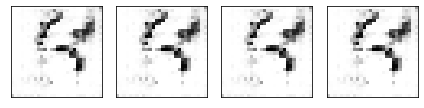

Epoch: 19 Loss D.: 0.7365902066230774
Epoch: 19 Loss G.: 0.9586015939712524


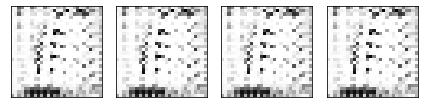

Epoch: 20 Loss D.: 0.7761894464492798
Epoch: 20 Loss G.: 0.932420015335083


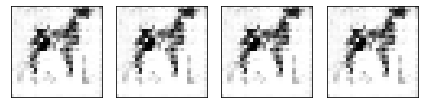

KeyboardInterrupt: ignored

In [ ]:
import os

# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in range(num_epochs):
      for n, (real_samples, mnist_labels) in enumerate(train_loader):
          ##############################
          ## update the discriminator
          ##############################
          batch_size = real_samples.size(0)
          noise = torch.randn((batch_size, 100))
          noise = noise.to(device)

          real_samples = real_samples.to(device)
          mnist_labels = mnist_labels.to(device)
          
          # zero the parameter gradients
          optimizer_discriminator.zero_grad()
          
          # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
          fake_samples = generator(noise)
          
          # forward du discriminator

          disc_real_output = discriminator(real_samples)
          #print(fake_samples.size())
          disc_fake_output = discriminator(fake_samples.detach()) # on detach fake_samples, car on n'a pas 
                                                                                # besoin d'avoir accès au gradient du generateur
          
          # calculate the loss for the discriminator
          loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
          
          # calculate the gradient for the discriminator
          loss_discriminator.backward()  
          
          # update the discriminator first
          optimizer_discriminator.step()
          
          ##############################
          ## update the Generator
          ##############################
          
          # zero the parameter gradients
          optimizer_generator.zero_grad()

          # forward du discriminator
          # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
          #print(fake_samples.size())
          disc_fake_output = discriminator(fake_samples)
          
          # calculate the loss for the generator
          loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
          
          # calculate the gradient for the discriminator
          loss_generator.backward() 
          
          # update the generator
          optimizer_generator.step()

          # Show loss
          if n == batch_size - 1:
              print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
              print(f"Epoch: {epoch} Loss G.: {loss_generator}")
              
              latent_space_samples = torch.randn(batch_size, 100).to(device=device)

              generated_samples = generator(latent_space_samples)
              generated_samples = generated_samples.cpu().detach()

              plt.figure()
              for i in range(4):
                  ax = plt.subplot(1, 4, i+1)
                  plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                  plt.xticks([])
                  plt.yticks([])
              plt.tight_layout()
              plt.show()